[![Notebook Tutorial](__code/__all/notebook_tutorial.png)](https://neutronimaging.ornl.gov/ct-reconstruction/)

<img src='__docs/notebook_rules.png' />

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib notebook

import imars3d
print(f"Using imarsd version {imars3d.__version__}")

from __code.imars3dui import Imars3dui
from __code.roi_selection_ui import Interface

from __code import system
system.System.select_working_dir()
from __code.__all import custom_style
custom_style.style()

Using imarsd version 1.1.0.dev256


** Using Debugging Mode! **


In [2]:
%gui qt

# Select input data 

## raw data

In [3]:
o_imars3dui = Imars3dui(working_dir=system.System.get_working_dir())
o_imars3dui.select_raw()

raw folder selected: ['/Users/j35/HFIR/CG1D/IPTS-28170-test_ct_reconstruction/raw/ct_scans/2022_03_16_nozzle'] with 1162 files)


## ob 

In [4]:
o_imars3dui.select_ob()

ob folder selected: ['/Users/j35/HFIR/CG1D/IPTS-28170-test_ct_reconstruction/raw/ob/2022_01_12_0BarSpray'] with 5 files)


## dc 

In [5]:
o_imars3dui.select_dc()

dc folder selected: ['/Users/j35/HFIR/CG1D/IPTS-28170-test_ct_reconstruction/raw/df/2022_01_10'] with 5 files)


# Load

ct:   0%|          | 0/1162 [00:00<?, ?it/s]

ob:   0%|          | 0/5 [00:00<?, ?it/s]

dc:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


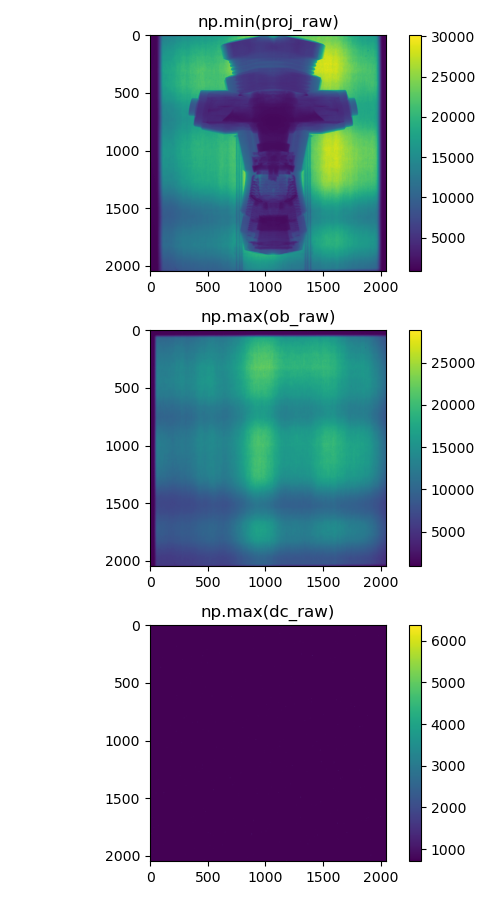

In [6]:
o_imars3dui.load_and_display_data()

# Crop

### select crop region (Zzz)

In [7]:
o_gui = Interface(o_imars3dui=o_imars3dui,
                  mode='crop',
                  callback=o_imars3dui.saving_crop_region)
o_gui.show()

### perform cropping 

In [8]:
o_imars3dui.crop_and_display_data()

Running crop ...
cropping done!


# Gamma filtering  (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [9]:
o_imars3dui.gamma_filtering()

Running gamma filtering ...
Gamma filtering done in 89.33s


# Normalization (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

Running normalization ...
normalization done in 38.47s


<IPython.core.display.Javascript object>


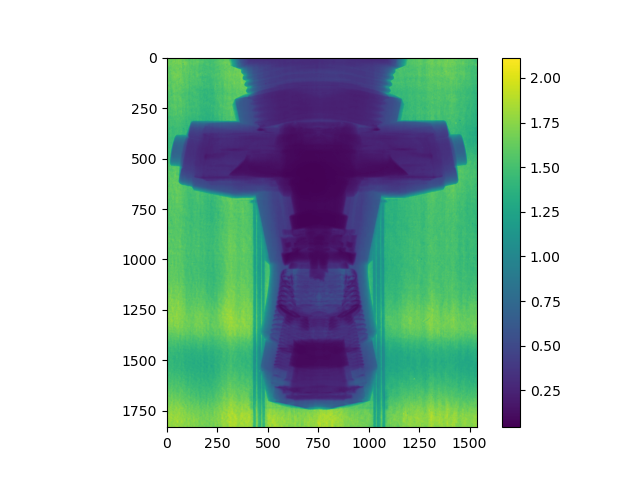

In [10]:
o_imars3dui.normalization_and_display()

# Beam fluctuation correction

### Select a region that does not contain the sample to improve the normalization

In [ ]:
o_gui = Interface(o_imars3dui=o_imars3dui,
                  mode='background',
                  callback=o_imars3dui.saving_beam_fluctuation_correction)
o_gui.show()

### perform beam fluctuation correction

In [ ]:
o_imars3dui.beam_fluctuation_correction()

# Transmission to attenuation

In [ ]:
o_imars3dui.minus_log_and_display()

# Tilt correction (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

## find 0 and 180 degrees files

In [ ]:
o_imars3dui.find_0_180_degrees_files()

## calculate tilt 

In [ ]:
o_imars3dui.calculate_tilt()

## apply tilt correction

In [ ]:
o_imars3dui.apply_tilt_and_display()

# Strikes removal (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

### using imars3d - ketcham method working on 3D stack

In [ ]:
o_imars3dui.strikes_removal()

# Rotation center (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [ ]:
o_imars3dui.rotation_center()

# Reconstruction 

In [ ]:
o_imars3dui.reconstruction_and_display()

# Export


In [ ]:
o_imars3dui.export()